## **Data Quality Framework study**

This studied data is from **KPMG - Virtual Internship**:

**Given task at hand**: *"The client has asked our team to assess the quality of their data; as well as make recommendations on ways to clean the underlying data and mitigate these issues."*

This purpose of these set of codes are the look into a data gathered from Excel by saving as CSV that was given from a customer. The customer wants to see how this data can be interpreted. To move forward with the data, we made a study on the quality of the data to inform the customer on **data quality framework**.

# **Transaction Data**

### **Step 1 - Read the data**

We read the data and take a look at first 5 rows.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import iqr
# import plotly.express as px
import matplotlib.pyplot as plt
from datetime import datetime, date
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
import warnings # For Github share, hide local file paths
warnings.filterwarnings('ignore')


transactions=pd.read_csv("data/transaction_id.csv", sep=';', encoding = "iso8859_9")
#Clearing any Unnamed column caused by encoding from the data
transactions=transactions.dropna(how='all', axis='columns')

#Fixing excel related data integer to actual date
transactions['product_first_sold_date'] = pd.to_datetime(transactions['product_first_sold_date'], unit='D', origin='1899-12-30')
transactions['transaction_date']=pd.to_datetime(transactions['transaction_date'], format="%d.%m.%Y")

#Dolar sign removal and Float data type
transactions['standard_cost'] = transactions['standard_cost'].str.replace('$', '').str.replace(".","").str.replace(",",".").astype(float)
transactions['list_price'] = transactions['list_price'].str.replace(",",".").astype(float)

#Replace all Turkish True and False values with 1 and 0
transactions['online_order'] = transactions['online_order'].str.replace("YANLIŞ","0").str.replace("DOĞRU","1")

#Approved and Cancelled can be replaced with 1 and 0 as well
transactions['order_status'] = transactions['order_status'].str.replace("Cancelled","0").str.replace("Approved","1")

# %2,775 of data is missing, we will drop this rows
tr_nan_values=transactions.isnull().mean() * 100
# print(tr_nan_values)
tr_nan_values=transactions[transactions.isna().any(axis=1)]
# print(len(tr_nan_values)/len(transactions)*100)
transactions=transactions.dropna()

#Dropping cancelled orders
transactions=transactions[transactions["order_status"]=="1"]



# **New Customer List**

In [2]:

newcustomer=pd.read_csv("data/newcustomerlist.csv", sep=';', encoding = "iso8859_9")

#Clearing any Unnamed column caused by encoding from the data
newcustomer=newcustomer.dropna(how='all', axis='columns')
# transactions=transactions.drop(transactions.columns[transactions.columns.str.contains('Unnamed',case = False)],axis = 1)
newcustomer = newcustomer.loc[:, ~newcustomer.columns.str.contains('^Unnamed')]
newcustomer['DOB']=pd.to_datetime(newcustomer['DOB'], format="%Y-%m-%d")
newcustomer['Value'] = newcustomer['Value'].str.replace(",",".").astype(float)

#newcustomer genders
newcustomer["gender"]=newcustomer["gender"].replace('U',np.NaN)
newcustomer["gender"]=newcustomer["gender"].replace('Male',0)
newcustomer["gender"]=newcustomer["gender"].replace('Female',1)
newcustomer['deceased_indicator'] = 1*(newcustomer['deceased_indicator'] == "N")
newcustomer['owns_car'] = 1*(newcustomer['owns_car'] == "Yes")
newcustomer["property_valuation"]=newcustomer["property_valuation"].str.replace(",",".").astype(float)

one_hot1 = OneHotEncoder()
encoded = one_hot1.fit_transform(newcustomer[['wealth_segment']])
newcustomer[one_hot1.categories_[0]]=encoded.toarray()


#Dropping first and last name
newcustomer=newcustomer.drop(["first_name","last_name"],axis=1)


# This function converts given date to age
def age(born):
	# born = datetime.strptime(born, "%d/%m/%Y").date()
	today = date.today()
	return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

newcustomer["Age"]=newcustomer["DOB"].apply(age)
newcustomer=newcustomer.drop("DOB",axis=1)
newcustomer["age_group"]=pd.cut(newcustomer["Age"],bins=[17,30,45,60,150],labels=["17-30","31-45","45-60","60 and above"])

#Observe missing values
# count_nan = newcustomer.isnull().sum()
# print(count_nan)
 
newcustomer=newcustomer.dropna(subset=["gender","Age"])

# **Customer Demographic**

In [3]:
customerdemographic=pd.read_csv("data/customerdemographic.csv", sep=';', encoding = "iso8859_9")

#Clearing any Unnamed column caused by encoding from the data
customerdemographic=customerdemographic.dropna(how='all', axis='columns')

#Column "default" includes data that is either corrupted or encoded in a way that is alien to us, so it is discarded.
customerdemographic=customerdemographic.drop(["default"],axis=1)

#Changing str Date to pandas date time
customerdemographic['DOB']=pd.to_datetime(customerdemographic['DOB'], format="%Y-%m-%d")

customerdemographic["gender"]=customerdemographic["gender"].replace(to_replace=["F","Femal"], value='Female').replace(to_replace='M', value='Male')

customerdemographic["DOB"].loc[(customerdemographic["DOB"]=="1843-12-21 00:00:00")]=customerdemographic["DOB"].mean()

customerdemographic["Age"]=customerdemographic["DOB"].apply(age)
customerdemographic=customerdemographic.drop("DOB",axis=1)


# print(customerdemographic.head())
tr_nan_values=customerdemographic[customerdemographic.isna().any(axis=1)]
count_nan = customerdemographic.isnull().sum()
print(count_nan)




customer_id                              0
first_name                               0
last_name                              125
gender                                   0
past_3_years_bike_related_purchases      0
job_title                              506
job_industry_category                  656
wealth_segment                           0
deceased_indicator                       0
owns_car                                 0
tenure                                  87
Age                                     87
dtype: int64


## **Imputing Missing Values**

-Gender will be imputed,

-Tenure will be imputed,

-Age will be imputed,

-However, **job_title and job_industry_category won't be imputed**

**Before imputing, we will:**
remove first name last name


turn into classification:
deceased indicator, wealth segment, owns car


remove job_title and job_industry category for imputing of tenure, age and Gender, inorder

In [4]:
# def impute_categorical(categorical_column1, categorical_column2):
#     cat_frames = []
#     for i in list(set(df[categorical_column1])):
#         df_category = df[df[categorical_column1]== i]
#         if len(df_category) > 1:    
#             df_category[categorical_column2].fillna(df_category[categorical_column2].mode()[0],inplace = True)        
#         else:
#             df_category[categorical_column2].fillna(df[categorical_column2].mode()[0],inplace = True)
#         cat_frames.append(df_category)    
#         cat_df = pd.concat(cat_frames)
#     return cat_df 

#Removing first and last names
customerdemographic=customerdemographic.drop(["first_name","last_name"],axis=1)

#One Hot Encoding Multiclass wealth_segment

one_hot = OneHotEncoder()
encoded = one_hot.fit_transform(customerdemographic[['wealth_segment']])

# 0-1 Classification of gender, deceased_indicator, owns_car
customerdemographic["gender"]=customerdemographic["gender"].replace('U',np.NaN)
customerdemographic["gender"]=customerdemographic["gender"].replace('Male',0)
customerdemographic["gender"]=customerdemographic["gender"].replace('Female',1)
# customerdemographic['gender'] = 1*(customerdemographic['gender'] == "Female")
print(customerdemographic["gender"].unique())
customerdemographic['deceased_indicator'] = 1*(customerdemographic['deceased_indicator'] == "N")
customerdemographic['owns_car'] = 1*(customerdemographic['owns_car'] == "Yes")
customerdemographic[one_hot.categories_[0]]=encoded.toarray()

#Removing old wealth_segment column
# customerdemographic=customerdemographic.drop(["wealth_segment"],axis=1)

#Removing job_title and job_industry_category for following imputing requirement
customerdemographic_impt=customerdemographic.drop(["job_title","job_industry_category","wealth_segment"],axis=1)
columns=customerdemographic_impt.columns
# customerdemographic.to_csv("observationcustomerdemo.csv")
print(columns)


[ 1.  0. nan]
Index(['customer_id', 'gender', 'past_3_years_bike_related_purchases',
       'deceased_indicator', 'owns_car', 'tenure', 'Age', 'Affluent Customer',
       'High Net Worth', 'Mass Customer'],
      dtype='object')


## **Imputing Part**

In [5]:
#Impute our Data
customerdemographic_impt=KNNImputer(n_neighbors=3).fit_transform(customerdemographic_impt)
print(customerdemographic_impt)
#Classify from probility
customerdemographic_impt[:,1]=np.where(customerdemographic_impt[:,1]> 0.5, 1, 0)

#Return to Dataframe
customerdemographic_impt=pd.DataFrame(customerdemographic_impt, columns = columns)


count_nan = customerdemographic_impt.isnull().sum()
print(count_nan)

customerdemographic=customerdemographic_impt.join(customerdemographic[["job_title","job_industry_category","wealth_segment"]])
customerdemographic["age_group"]=pd.cut(customerdemographic["Age"],bins=[17,30,45,60,150],labels=["17-30","31-45","45-60","60 and above"])
# customerdemographic.to_csv("observationcustomerdemo.csv")
print(customerdemographic["gender"].unique())

[[1.000e+00 1.000e+00 9.300e+01 ... 0.000e+00 0.000e+00 1.000e+00]
 [2.000e+00 0.000e+00 8.100e+01 ... 0.000e+00 0.000e+00 1.000e+00]
 [3.000e+00 0.000e+00 6.100e+01 ... 0.000e+00 0.000e+00 1.000e+00]
 ...
 [3.998e+03 0.000e+00 6.000e+01 ... 0.000e+00 1.000e+00 0.000e+00]
 [3.999e+03 0.000e+00 1.100e+01 ... 1.000e+00 0.000e+00 0.000e+00]
 [4.000e+03 0.000e+00 7.600e+01 ... 1.000e+00 0.000e+00 0.000e+00]]
customer_id                            0
gender                                 0
past_3_years_bike_related_purchases    0
deceased_indicator                     0
owns_car                               0
tenure                                 0
Age                                    0
Affluent Customer                      0
High Net Worth                         0
Mass Customer                          0
dtype: int64
[1. 0.]


# **Customer Adress**

In [6]:


customeradress=pd.read_csv("data/customeradress.csv", sep=';', encoding = "iso8859_9")

#Clearing any Unnamed column caused by encoding from the data
customeradress=customeradress.dropna(how='all', axis='columns')

customeradress["state"]=customeradress["state"].str.replace("New South Wales","NSW").replace("Victoria", "VIC")
# Removing country column as all the values are same and postcode as there are too much classification to create any methods of guessing
customeradress=customeradress.drop(["country","postcode"],axis=1)
# Adress with exact street is not useful as too much different possibilities exist, but we can create a groupable dataset by removing numerical values from adress to focus on area
customeradress['address'] = customeradress['address'].str.replace('\d+', '')
customeradress.head()



customer_id              address state  property_valuation
0            1   060 Morning Avenue   NSW                  10
1            2  6 Meadow Vale Court   NSW                  10
2            4   0 Holy Cross Court   QLD                   9
3            5  17979 Del Mar Point   NSW                   4
4            6     9 Oakridge Court   VIC                   9

# **Explatory Data Analysis**

Here we first look into heads of all three data set we have, from here we will try to start connecting dots

First thing first, connecting transactions with customer information

For that we will use customer_id from transaction and find values from customer informations with matching customer_id, creating the desired dataset

In [7]:
df = pd.merge(pd.merge(transactions, customerdemographic, on='customer_id'),customeradress,on='customer_id')
df["profit"]=df["list_price"]-df["standard_cost"]
# df.to_excel("df.xlsx",engine='xlsxwriter')
#Save our csv in custom mode from clean data load in Power Bi
#df.to_csv("df_modified.csv",decimal=",",sep="=")
# df.head()
print(2+3)

5


### Correlation

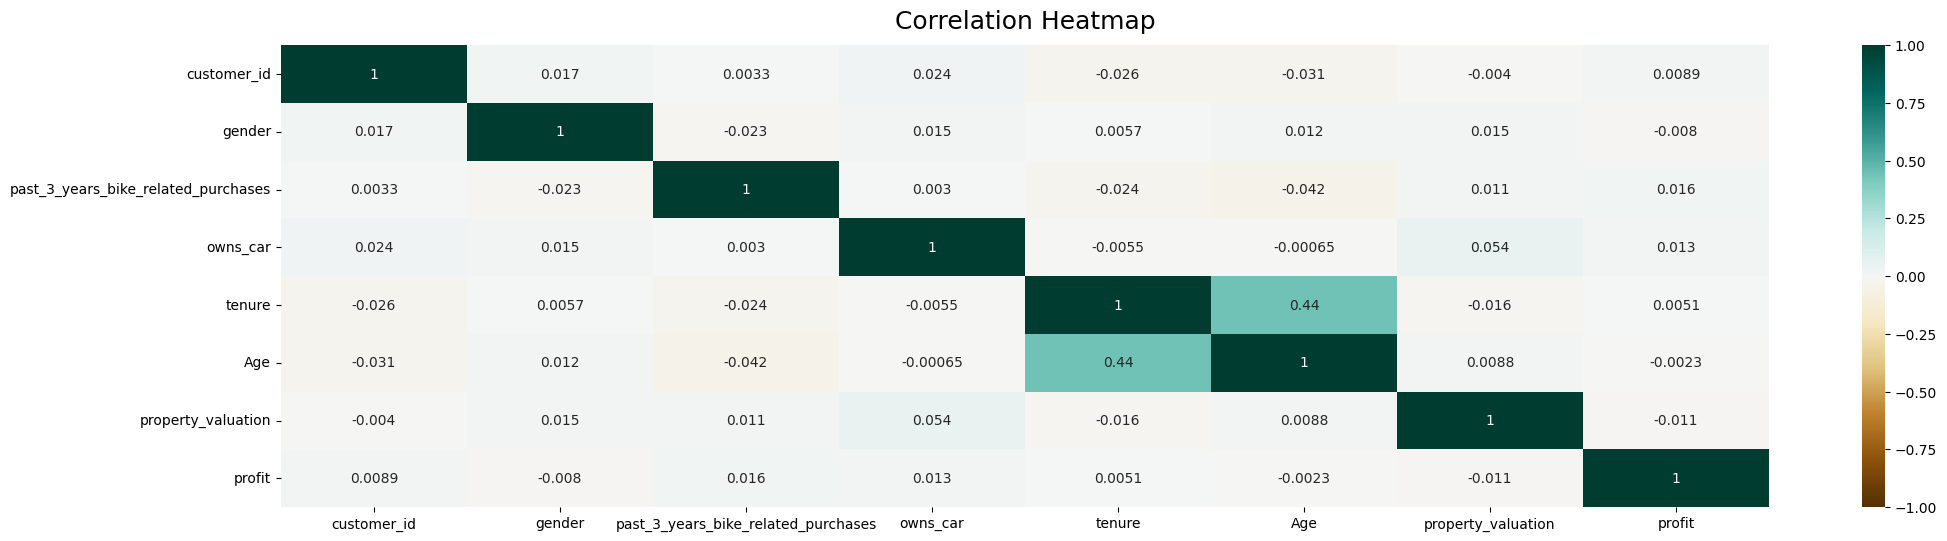

In [10]:
cor=df[["customer_id","gender","past_3_years_bike_related_purchases","owns_car","tenure","Age","property_valuation","profit"]]
plt.figure(figsize=(24, 6))
heatmap = sns.heatmap(cor.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
# save heatmap as .png file
# dpi - sets the resolution of the saved image in dots/inches
# bbox_inches - when set to 'tight' - does not allow the labels to be cropped
#plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

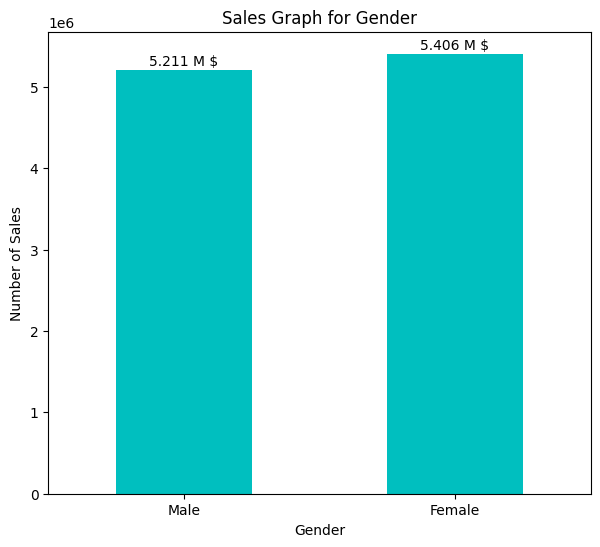

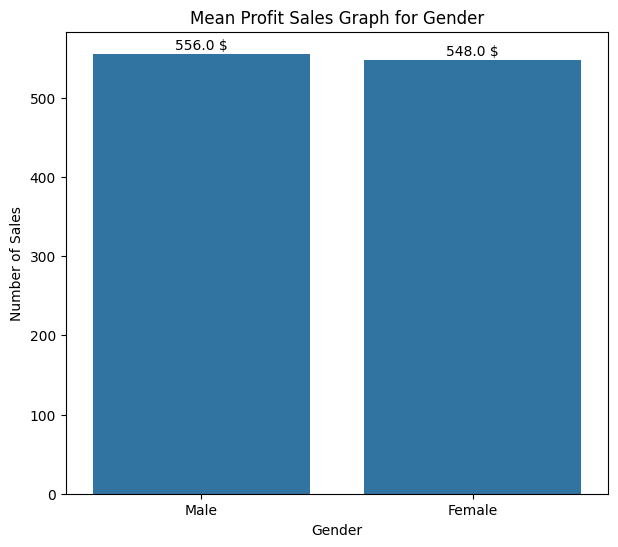

In [11]:
df_gender = df.groupby(["gender"])["profit"].sum()
plt.figure(figsize=(7, 6))
ax = df_gender.plot(kind='bar', rot=0, color="c")
ax.set_title("Sales Graph for Gender", y = 1)
ax.set_xlabel('Gender')
ax.set_ylabel('Number of Sales')
ax.set_xticklabels(('Male', 'Female'))

for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = format(round(y_value/1000000,3))
    ax.annotate(label+" M $", (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')    
plt.show()

plt.figure(figsize=(7, 6))
ax = sns.barplot(data=df, x="gender", y="profit",ci=None)
ax.set_title("Mean Profit Sales Graph for Gender", y = 1)
ax.set_xlabel('Gender')
ax.set_ylabel('Number of Sales')
ax.set_xticklabels(('Male', 'Female'))
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = format(round(y_value,0))
    ax.annotate(label+" $", (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')   
plt.show()

### **Industry Groups**

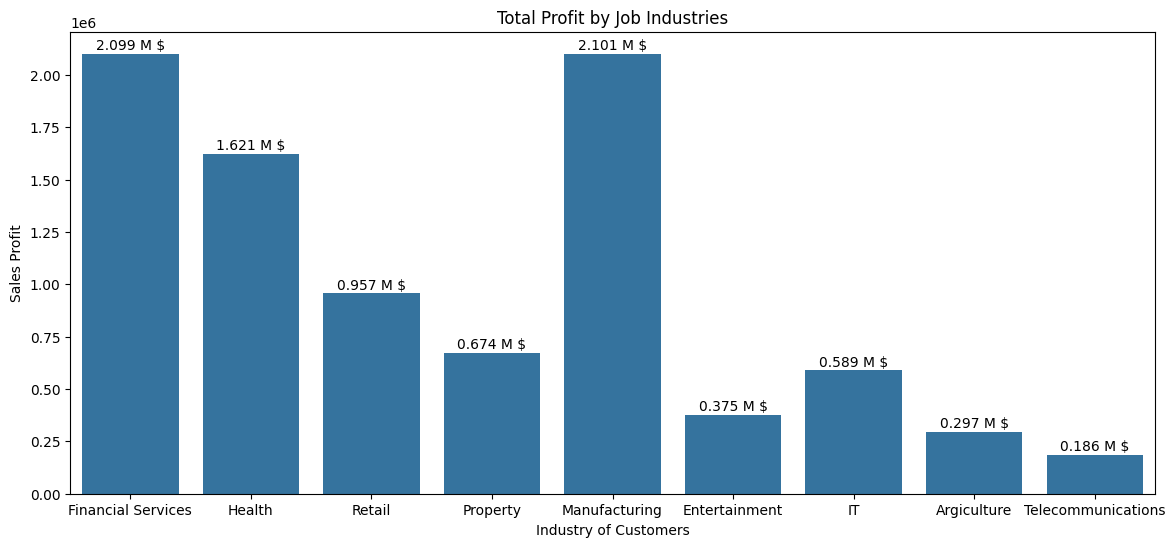

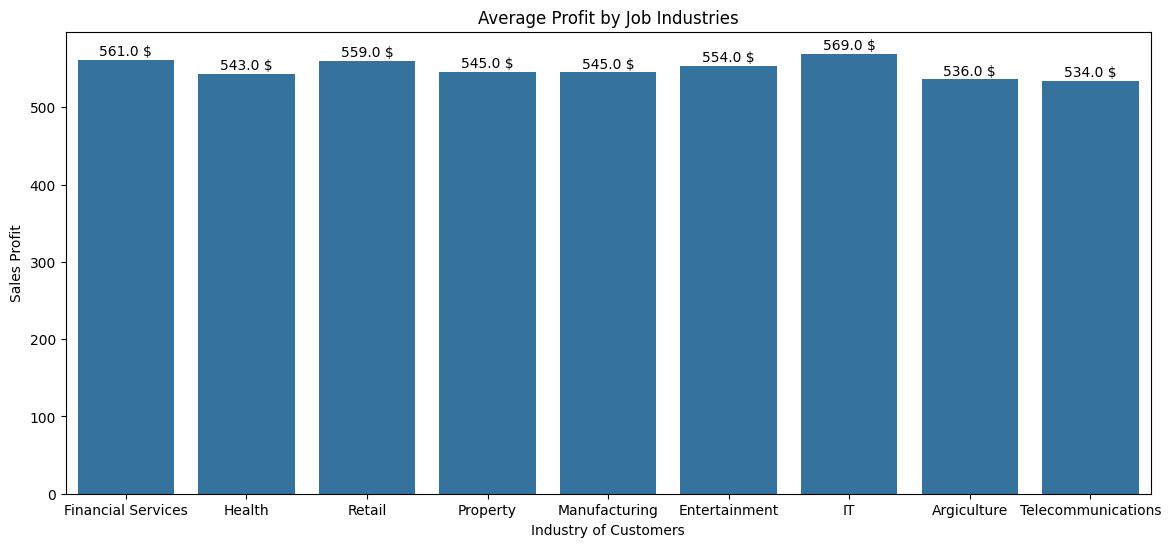

In [12]:
plt.figure(figsize=(14, 6))
ax = sns.barplot(data=df, x="job_industry_category", y="profit",estimator=sum,saturation=.7,ci=None)
ax.set_title("Total Profit by Job Industries", y = 1)
ax.set_ylabel('Sales Profit')
ax.set_xlabel('Industry of Customers')
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = format(round(y_value/1000000,3))
    ax.annotate(label+" M $", (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')    
plt.show()

plt.figure(figsize=(14, 6))
ax = sns.barplot(data=df, x="job_industry_category", y="profit",saturation=.7,ci=None)
ax.set_title("Average Profit by Job Industries", y = 1)
ax.set_ylabel('Sales Profit')
ax.set_xlabel('Industry of Customers')
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = format(round(y_value,0))
    ax.annotate(label+" $", (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')    
plt.show()


From job industry we can interpret that in general people from different industries tend to spend around same in shopping. People in financial services and manufacturing creates the highest two profit group, these people are more likely to buy targeted products.

### **Age Groups**

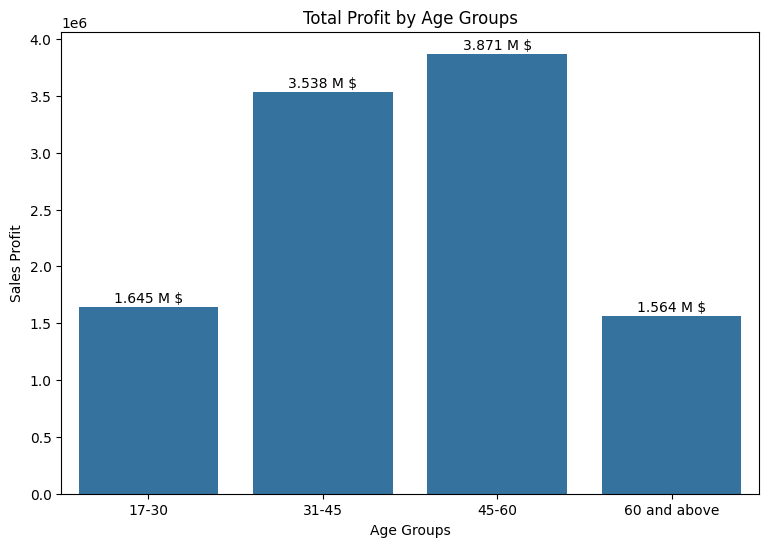

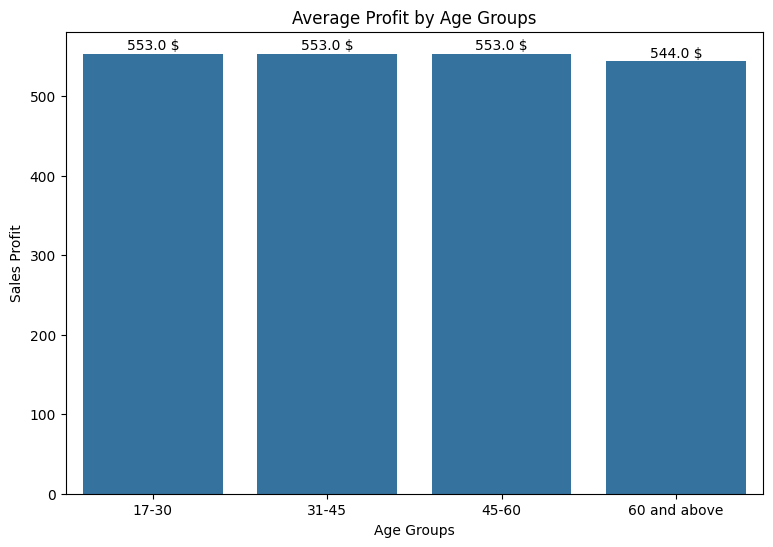

In [13]:
plt.figure(figsize=(9, 6))
ax = sns.barplot(data=df, x="age_group", y="profit",estimator=sum,saturation=.7,ci=None)
ax.set_title("Total Profit by Age Groups", y = 1)
ax.set_ylabel('Sales Profit')
ax.set_xlabel('Age Groups')
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = format(round(y_value/1000000,3))
    ax.annotate(label+" M $", (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')    
plt.show()

plt.figure(figsize=(9, 6))
ax = sns.barplot(data=df, x="age_group", y="profit",saturation=.7,ci=None)
ax.set_title("Average Profit by Age Groups", y = 1)
ax.set_ylabel('Sales Profit')
ax.set_xlabel('Age Groups')
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = format(round(y_value,0))
    ax.annotate(label+" $", (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')    
plt.show()

Again, between age groups, average spending is around same. Age group between 31-45 populate the highest total sales, followed by 45-60.

### **Wealth Segments**

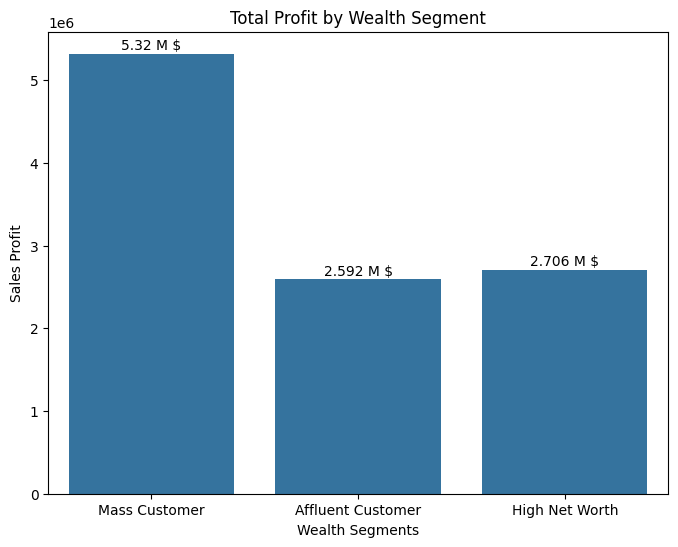

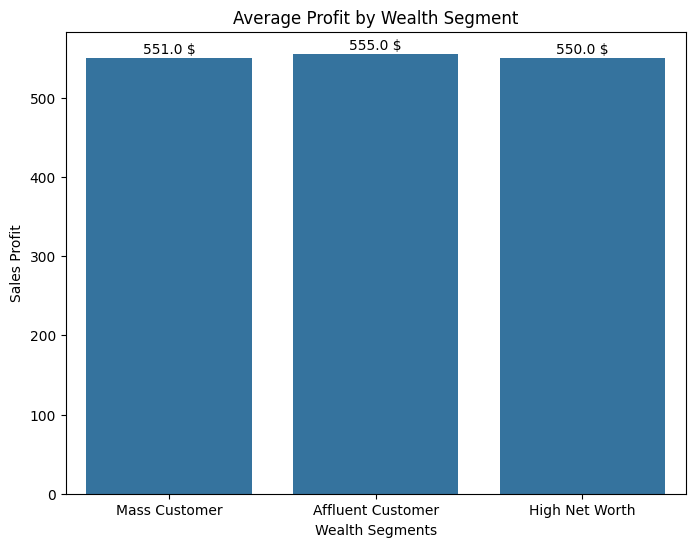

In [14]:
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=df, x="wealth_segment", y="profit",estimator=sum,saturation=.7,ci=None)
ax.set_title("Total Profit by Wealth Segment", y = 1)
ax.set_ylabel('Sales Profit')
ax.set_xlabel('Wealth Segments')
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = format(round(y_value/1000000,3))
    ax.annotate(label+" M $", (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')    
plt.show()

plt.figure(figsize=(8, 6))
ax = sns.barplot(data=df, x="wealth_segment", y="profit",saturation=.7,ci=None)
ax.set_title("Average Profit by Wealth Segment", y = 1)
ax.set_ylabel('Sales Profit')
ax.set_xlabel('Wealth Segments')
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = format(round(y_value,0))
    ax.annotate(label+" $", (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')    
plt.show()

High Net Worth wealth segment create the same average profit as Mass Customer. The most profit is gathered from sales of Mass Customers.

## **Looking at the sold products**

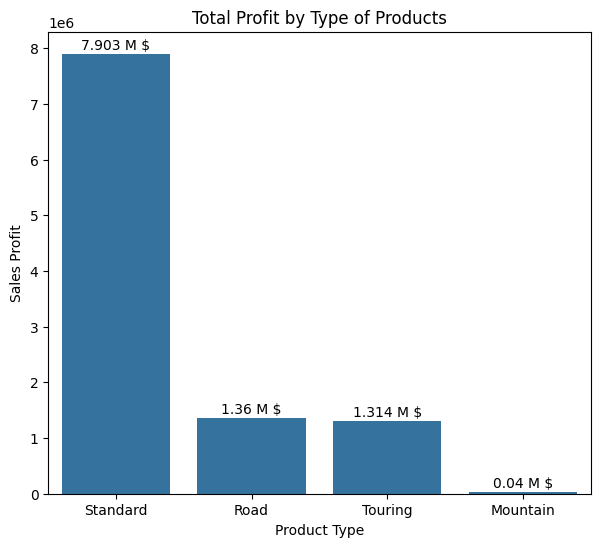

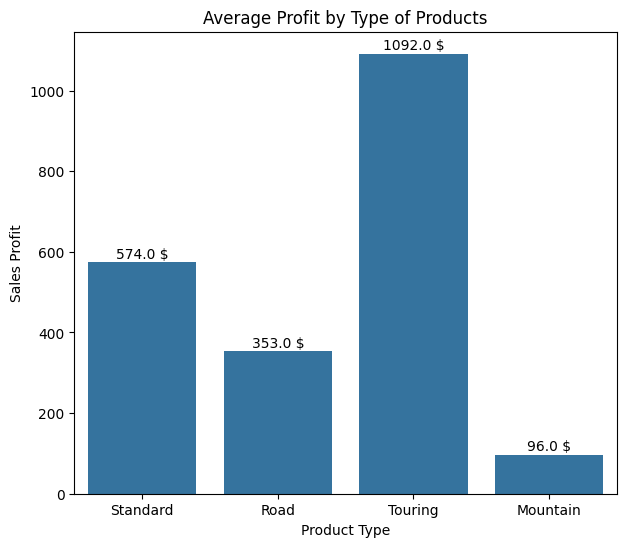

In [15]:
plt.figure(figsize=(7, 6))
ax = sns.barplot(data=df, x="product_line", y="profit",estimator=sum,saturation=.7,ci=None)
ax.set_title("Total Profit by Type of Products", y = 1)
ax.set_ylabel('Sales Profit')
ax.set_xlabel('Product Type')
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = format(round(y_value/1000000,3))
    ax.annotate(label+" M $", (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')    
plt.show()

plt.figure(figsize=(7, 6))
ax = sns.barplot(data=df, x="product_line", y="profit",saturation=.7,ci=None)
ax.set_title("Average Profit by Type of Products", y = 1)
ax.set_ylabel('Sales Profit')
ax.set_xlabel('Product Type')
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = format(round(y_value,0))
    ax.annotate(label+" $", (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')    
plt.show()

We have interesting two graphs here.

In overall profit, standard products gives the highest sales profit. Road and Touring products give about same profit while the least profitable type seems to be Mountain type products.

However, we can also see that Touring bicycles gives a lot of profit on average, meaning that each individual sale brings more profit. This can interpret also as high profit sales, hinting for a low investment manufacturing cost with high profit.

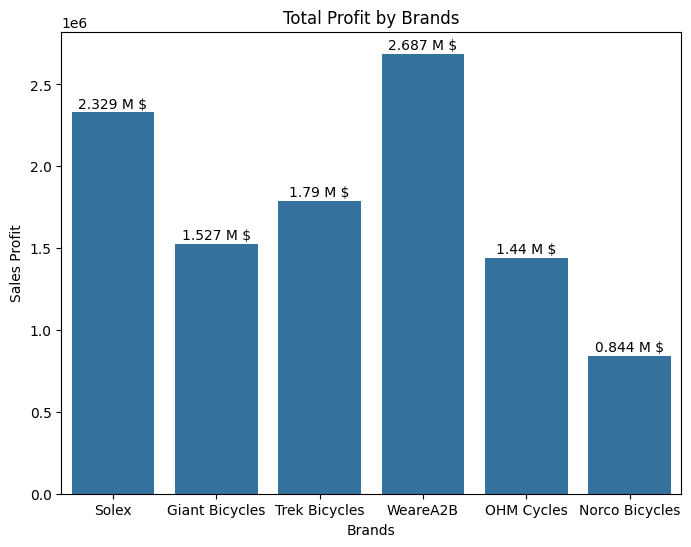

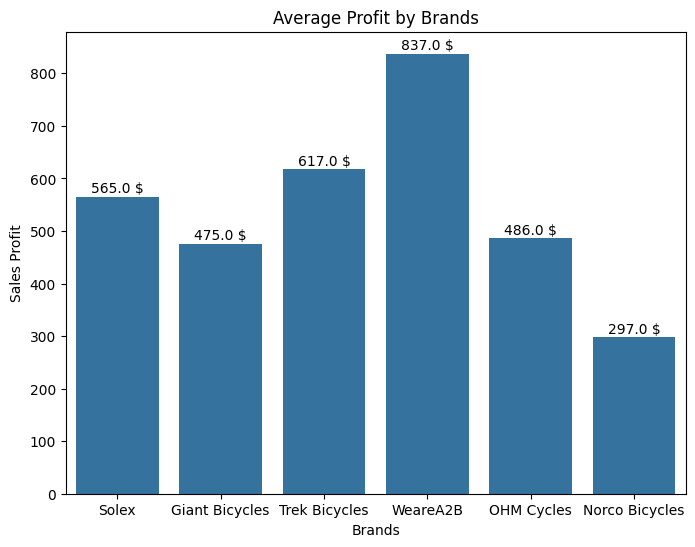

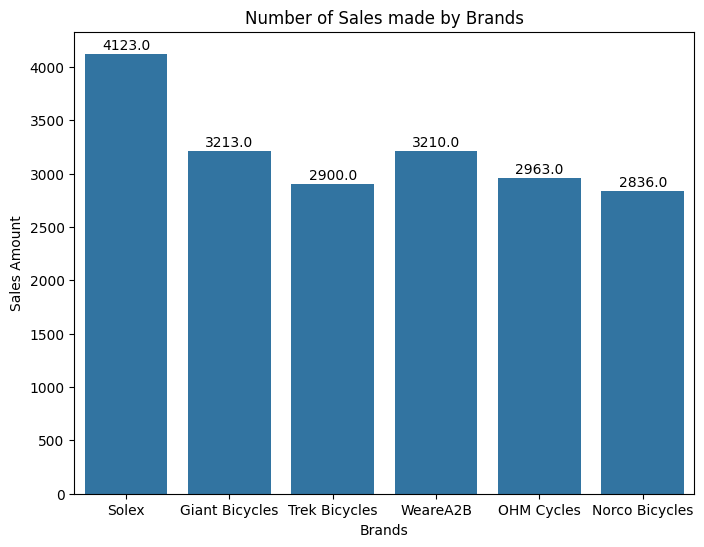

In [16]:
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=df, x="brand", y="profit",estimator=sum,saturation=.7,ci=None)
ax.set_title("Total Profit by Brands", y = 1)
ax.set_ylabel('Sales Profit')
ax.set_xlabel('Brands')
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = format(round(y_value/1000000,3))
    ax.annotate(label+" M $", (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')    
plt.show()

plt.figure(figsize=(8, 6))
ax = sns.barplot(data=df, x="brand", y="profit",saturation=.7,ci=None)
ax.set_title("Average Profit by Brands", y = 1)
ax.set_ylabel('Sales Profit')
ax.set_xlabel('Brands')
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = format(round(y_value,0))
    ax.annotate(label+" $", (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')    
plt.show()

plt.figure(figsize=(8, 6))
ax = sns.countplot(x=df["brand"])
ax.set_title("Number of Sales made by Brands", y = 1)
ax.set_ylabel('Sales Amount')
ax.set_xlabel('Brands')
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = format(round(y_value,0))
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')    
plt.show()

From these graph, a few important points can be observed.

Although the number of sale between Giant Bicycles and WeareA2B is an same level, the profit of WeareA2B is much higher than Giant Bicycles. 

What makes the product of WeareA2B more desirable for the customers such that they are willing to spend more money on it?

Also other than Solex, most companies have around same number of sales. But what difference causes the Solex to be at the top of the number of sales.

This points are important in order to find out what these brands are doing correct, what are their advertisements focus on, what difference those their products delivers and so on. One can never know enough on the opponent.

### **Product Class**

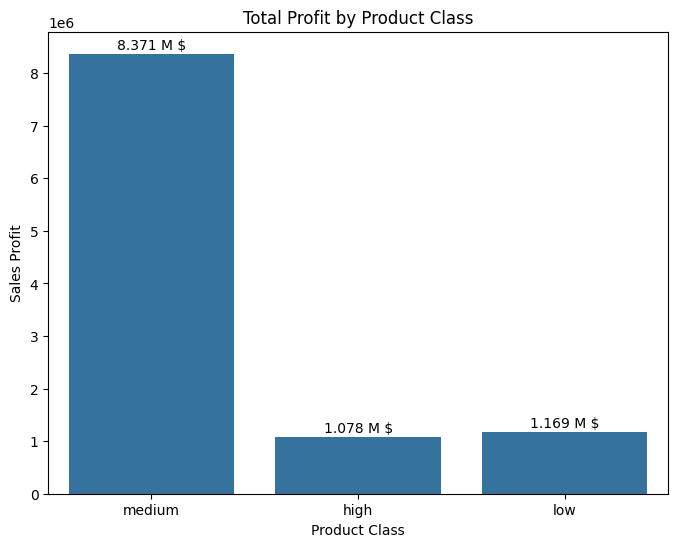

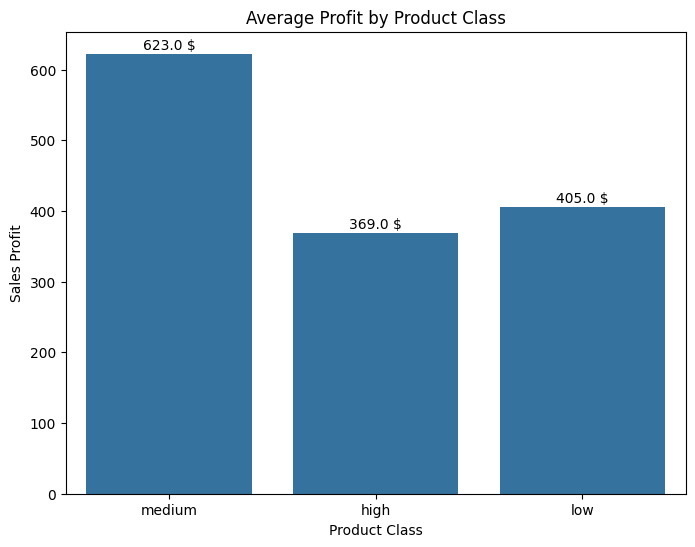

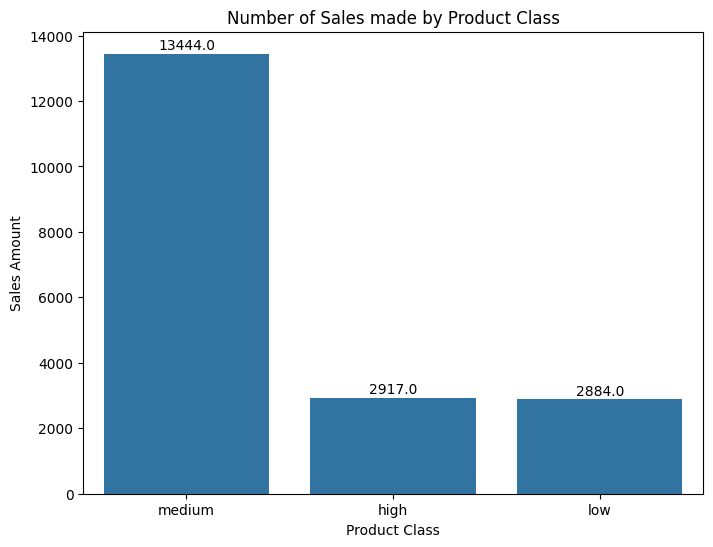

In [17]:
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=df, x="product_class", y="profit",estimator=sum,saturation=.7,ci=None)
ax.set_title("Total Profit by Product Class", y = 1)
ax.set_ylabel('Sales Profit')
ax.set_xlabel('Product Class')
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = format(round(y_value/1000000,3))
    ax.annotate(label+" M $", (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')    
plt.show()

plt.figure(figsize=(8, 6))
ax = sns.barplot(data=df, x="product_class", y="profit",saturation=.7,ci=None)
ax.set_title("Average Profit by Product Class", y = 1)
ax.set_ylabel('Sales Profit')
ax.set_xlabel('Product Class')
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = format(round(y_value,0))
    ax.annotate(label+" $", (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')    
plt.show()

plt.figure(figsize=(8, 6))
ax = sns.countplot(x=df["product_class"])
ax.set_title("Number of Sales made by Product Class", y = 1)
ax.set_ylabel('Sales Amount')
ax.set_xlabel('Product Class')
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = format(round(y_value,0))
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')    
plt.show()

For the first investment, medium products are much better option to produce. They sale more, on average have higher profit and total profit is highest for medium class bicycles

# **Old and New Customers**

We gathered information on the sales from the old customers transactions, but what is our new customers look like? To find out we can make some comparison graphs

In [18]:
#We make a new merged dataframe, but first add new columns to each old and new customers dataframe
customerdemographic["Cust"]="Old"
newcustomer["Cust"]="New"

#Merge
df_merg=pd.concat([customerdemographic, newcustomer])
df_merg.head()

#Save our csv in custom mode from clean data load in Power Bi
# df_merg.to_csv("df_merg_modified.csv",decimal=",",sep="=")

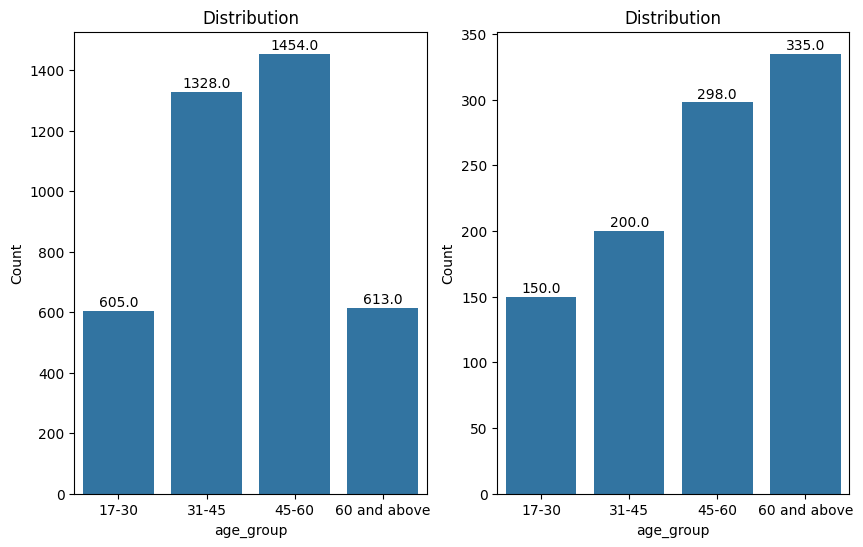

In [19]:
fig, axes =plt.subplots(1,2,figsize=(10,6))
sns.countplot(x=df_merg[df_merg["Cust"]=="Old"]["age_group"],ax=axes[0])
sns.countplot(x=df_merg[df_merg["Cust"]=="New"]["age_group"],ax=axes[1])
for ax in axes:
	ax.set_title("Distribution", y = 1)
	ax.set_ylabel('Count')
	for rect in ax.patches:
		y_value = rect.get_height()
		x_value = rect.get_x() + rect.get_width() / 2
		space = 1
		label = format(round(y_value,0))
		ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')    
plt.show()

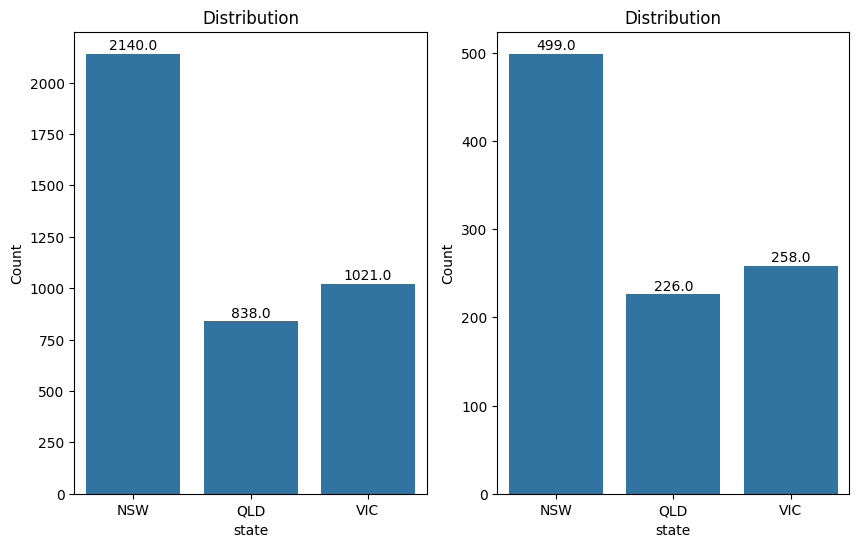

In [20]:
fig, axes =plt.subplots(1,2,figsize=(10,6))
sns.countplot(x=customeradress["state"].sort_values(),ax=axes[0])
sns.countplot(x=df_merg[df_merg["Cust"]=="New"]["state"].sort_values(),ax=axes[1])
for ax in axes:
	ax.set_title("Distribution", y = 1)
	ax.set_ylabel('Count')
	for rect in ax.patches:
		y_value = rect.get_height()
		x_value = rect.get_x() + rect.get_width() / 2
		space = 1
		label = format(round(y_value,0))
		ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')    
plt.show()

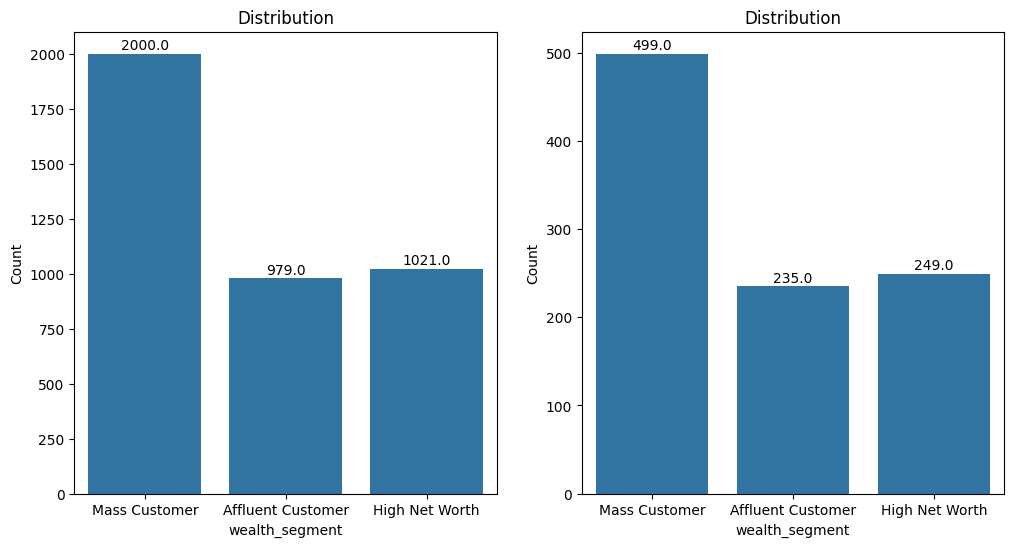

In [21]:
fig, axes =plt.subplots(1,2,figsize=(12,6))
sns.countplot(x=df_merg[df_merg["Cust"]=="Old"]["wealth_segment"],ax=axes[0])
sns.countplot(x=df_merg[df_merg["Cust"]=="New"]["wealth_segment"],ax=axes[1])
for ax in axes:
	ax.set_title("Distribution", y = 1)
	ax.set_ylabel('Count')
	for rect in ax.patches:
		y_value = rect.get_height()
		x_value = rect.get_x() + rect.get_width() / 2
		space = 1
		label = format(round(y_value,0))
		ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')   

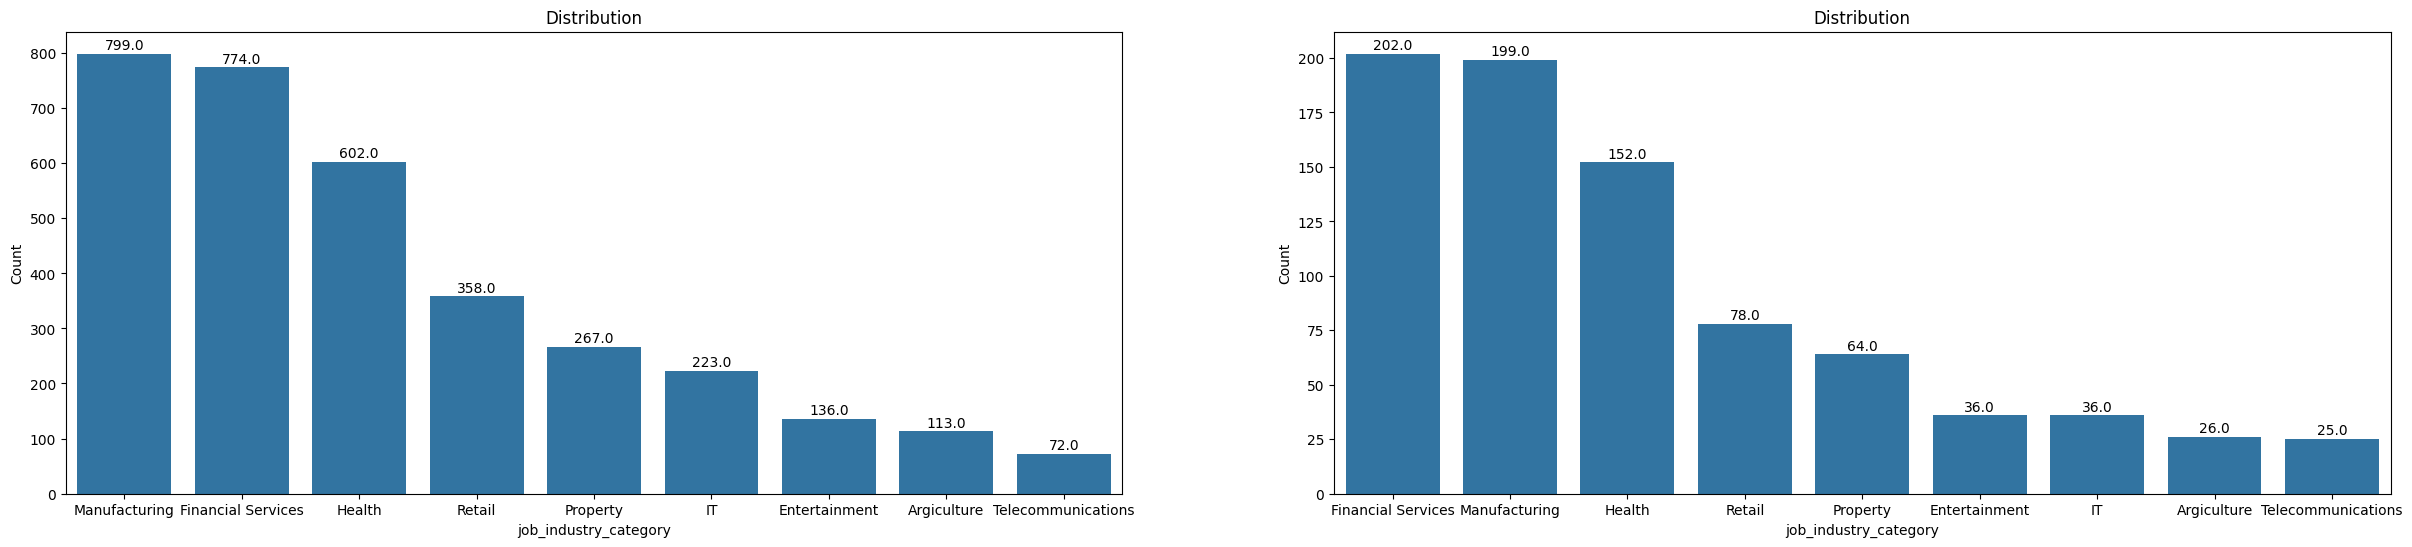

In [22]:
fig, axes =plt.subplots(1,2,figsize=(30,6))
sns.countplot(x=df_merg[df_merg["Cust"]=="Old"]["job_industry_category"],ax=axes[0],order = df_merg[df_merg["Cust"]=="Old"]["job_industry_category"].value_counts().index)
sns.countplot(x=df_merg[df_merg["Cust"]=="New"]["job_industry_category"],ax=axes[1],order = df_merg[df_merg["Cust"]=="New"]["job_industry_category"].value_counts().index)
for ax in axes:
	ax.set_title("Distribution", y = 1)
	ax.set_ylabel('Count')
	for rect in ax.patches:
		y_value = rect.get_height()
		x_value = rect.get_x() + rect.get_width() / 2
		space = 1
		label = format(round(y_value,0))
		ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')   

# **Model with Customer Importance**

For customer segmentation, we will use K-Means Clustering with Machine Learning

In [23]:
#We start by assigning the features we want to work with to a variable called data.
data = df[["past_3_years_bike_related_purchases", "Age", "tenure", "property_valuation","profit"]]
#We will transform features and save the result into a variable called data_log
# df_log = np.log(data)
df_log=data

In [24]:
#Then we will scale the result using Scikit-learn StandardScaler():
std_scaler = StandardScaler()
df_scaled = std_scaler.fit_transform(df_log)

[96225.0, 76867.28200733216, 66162.64293798862, 58071.252471104424, 51417.47430140541, 47798.877699597455, 45125.53982941955, 42719.84263566059, 40487.34377405815, 38441.729091998626]


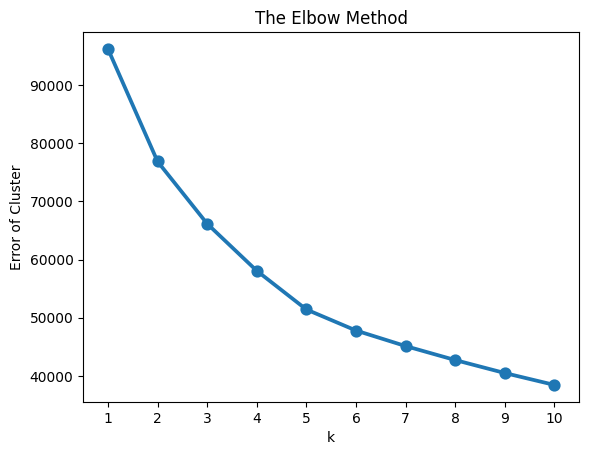

In [25]:
#To find best cluster number, we will try elbow method
errors = []
for k in range(1, 11):
	model = KMeans(n_clusters=k, random_state=42)
	model.fit(df_scaled)
	errors.append(model.inertia_)

print(errors)
plt.title('The Elbow Method')
plt.xlabel('k'); plt.ylabel('Error of Cluster')
sns.pointplot(x=list(range(1, 11)), y=errors)
plt.show()

The elbow point inthe graph is 5, where after 5 smoothing decreases

In [26]:
model = KMeans(n_clusters = 5, random_state=42)
model.fit(df_scaled)

KMeans(n_clusters=5, random_state=42)

In [27]:
#The next thing will be to assign the cluster label for each observation. So we will assign the label to the original feature we didn't processed.
df = df.assign(ClusterLabel = model.labels_)
df.head()

transaction_id  product_id  customer_id transaction_date online_order  \
0               1           2         2950       2017-02-25            0   
1           11065           1         2950       2017-10-16            0   
2           18923          62         2950       2017-04-26            0   
3               2           3         3120       2017-05-21            1   
4            6862           4         3120       2017-10-05            0   

  order_status           brand product_line product_class product_size  ...  \
0            1           Solex     Standard        medium       medium  ...   
1            1  Giant Bicycles     Standard        medium       medium  ...   
2            1           Solex     Standard        medium       medium  ...   
3            1   Trek Bicycles     Standard        medium        large  ...   
4            1  Giant Bicycles     Standard          high       medium  ...   

   Mass Customer            job_title job_industry_category  wealth_segment  \
0            1.0  Software Engineer I    Financial Services   Mass Customer   
1            1.0  Software Engineer I    Financial Services   Mass Customer   
2            1.0  Software Engineer I    Financial Services   Mass Customer   
3            1.0  Clinical Specialist                Health   Mass Customer   
4            1.0  Clinical Specialist                Health   Mass Customer   

      age_group            address  state  property_valuation   profit  \
0  60 and above  984 Hoepker Court    VIC                   6    17.87   
1  60 and above  984 Hoepker Court    VIC                   6   448.68   
2  60 and above  984 Hoepker Court    VIC                   6   179.44   
3         31-45    4 Shopko Circle    NSW                   5  1702.55   
4         31-45    4 Shopko Circle    NSW                   5   451.65   

   ClusterLabel  
0             0  
1             0  
2             0  
3             3  
4             4  

[5 rows x 31 columns]

In [29]:
output=df.groupby('ClusterLabel').agg({'past_3_years_bike_related_purchases':'mean', 
							'Age':'mean', 
							'tenure':'mean', 
							'property_valuation': 'mean', 
							'profit':['sum', 'mean'], 
							'owns_car':'mean',
							'Affluent Customer':'mean',
							'High Net Worth':'mean',
							'Mass Customer':'mean'}).round(1)
# output.to_excel("table.xlsx",engine='xlsxwriter')

- Cluster 4: **Most valuable customer group.** This group must be the main focus. Highest amount of sales profit achieving customer group. They are frequent purchaser, middle-aged adult with high property valuation and tenure. In average, this customer group also has higher profit mean. 
- Cluster 0: **Valuable customer group**. Second highest profitable customer group. They are young people with low tenure. These young people has high property valuation, hinting they are from wealthy families. These young adults must be attracted with advertisements for increasing profit. 
- Cluster 2: **Keep in touch.** People who makes bike purchases least amount. These people are not frequent buyers, but its important to keep in touch with these group as they generate considerable profit nevertheless. 
- Cluster 3: **Frequent Purchasers.** These people may not generate high profit, it is profitable to constantly send them reminders, advertisements, sales mail and other reaching methods to keep them on buyer state.
- Cluster 1: **Low revenue customers.** These people mainly live in low value property. Lowest revenue generating group. Should be last group to consider during advertisement budgetting.

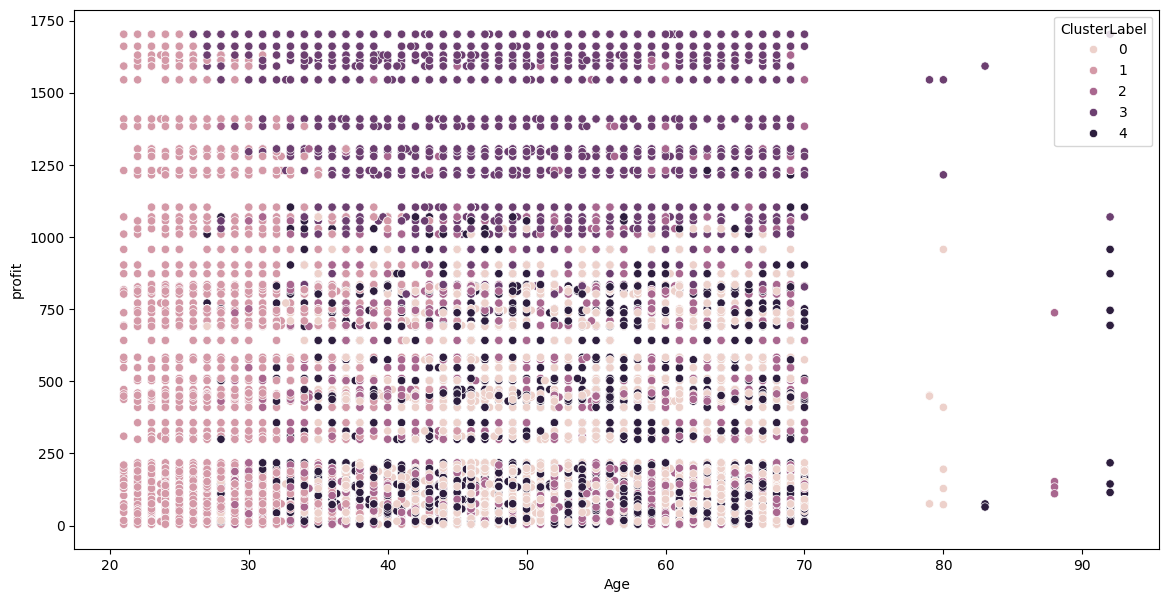

In [30]:
fig, ax =plt.subplots(1,figsize=(14,7))
ax = sns.scatterplot(
    data=df,
    x = "Age",
    y= "profit",
    hue = "ClusterLabel",
)
plt.show()


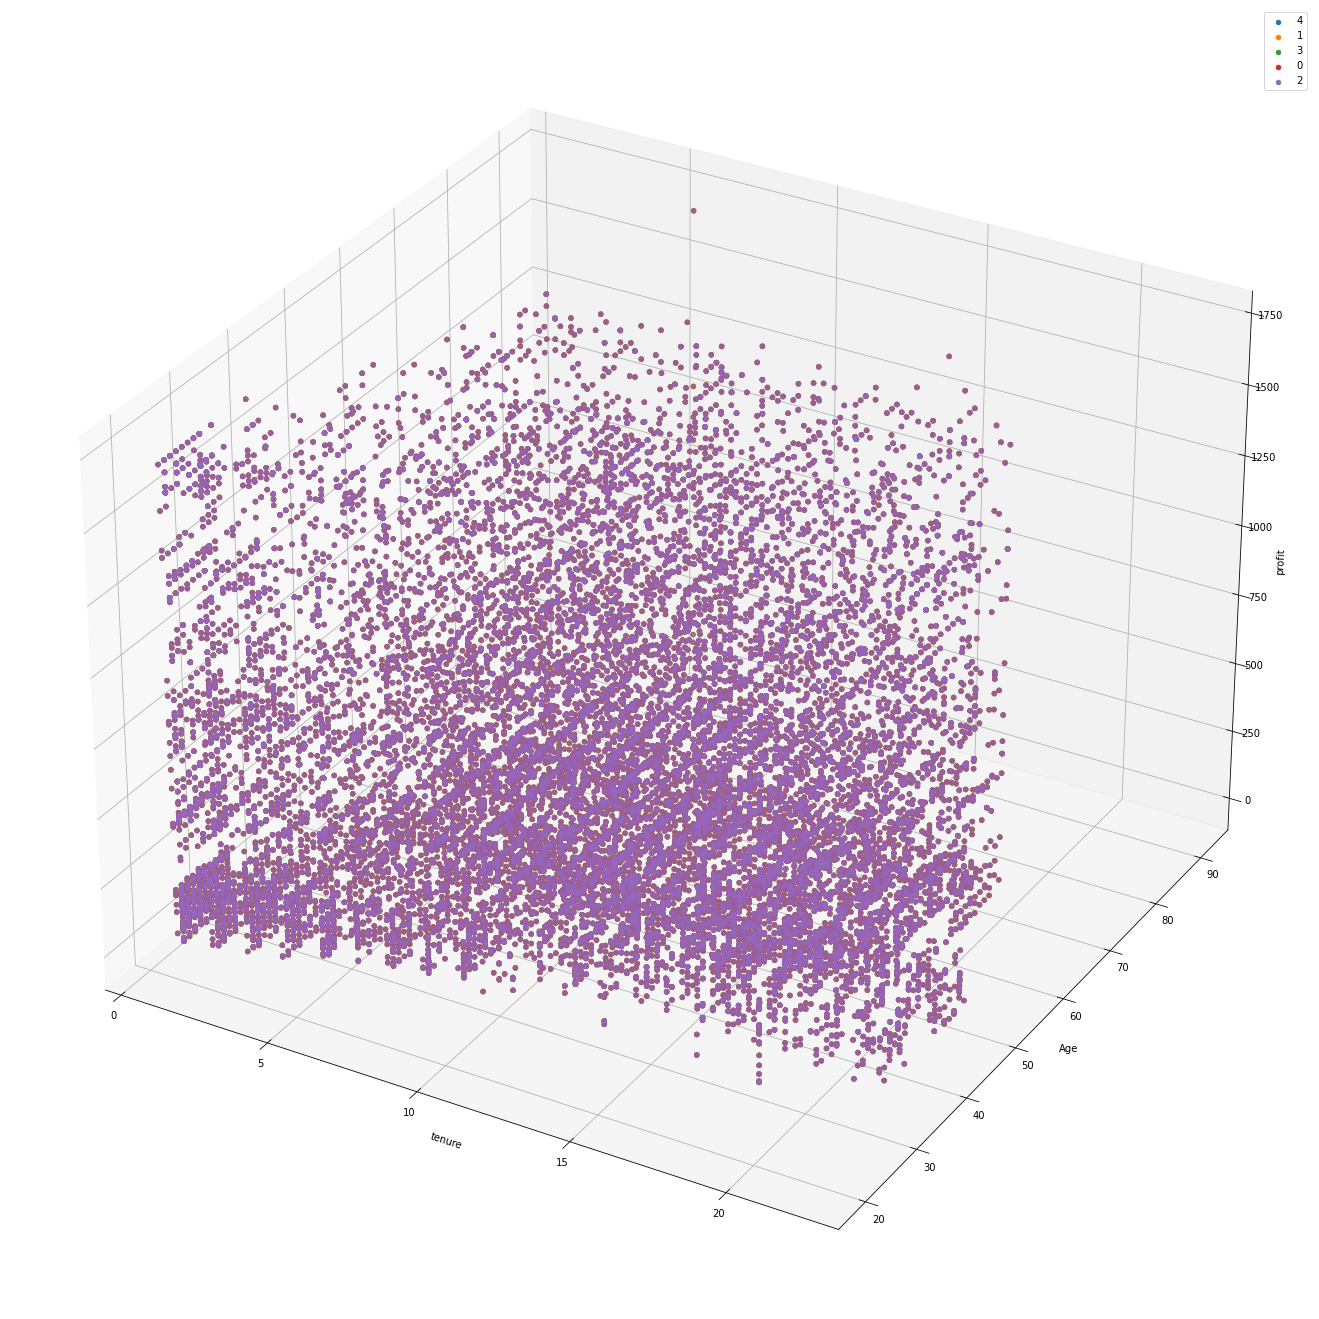

In [ ]:
fig = plt.figure(figsize=(24,24))
ax = fig.add_subplot(111, projection='3d')


for s in df.ClusterLabel.unique():
    ax.scatter(df["tenure"],df["Age"],df["profit"],label=s)
ax.set_xlabel('tenure')
ax.set_ylabel('Age')
ax.set_zlabel('profit')
ax.legend()

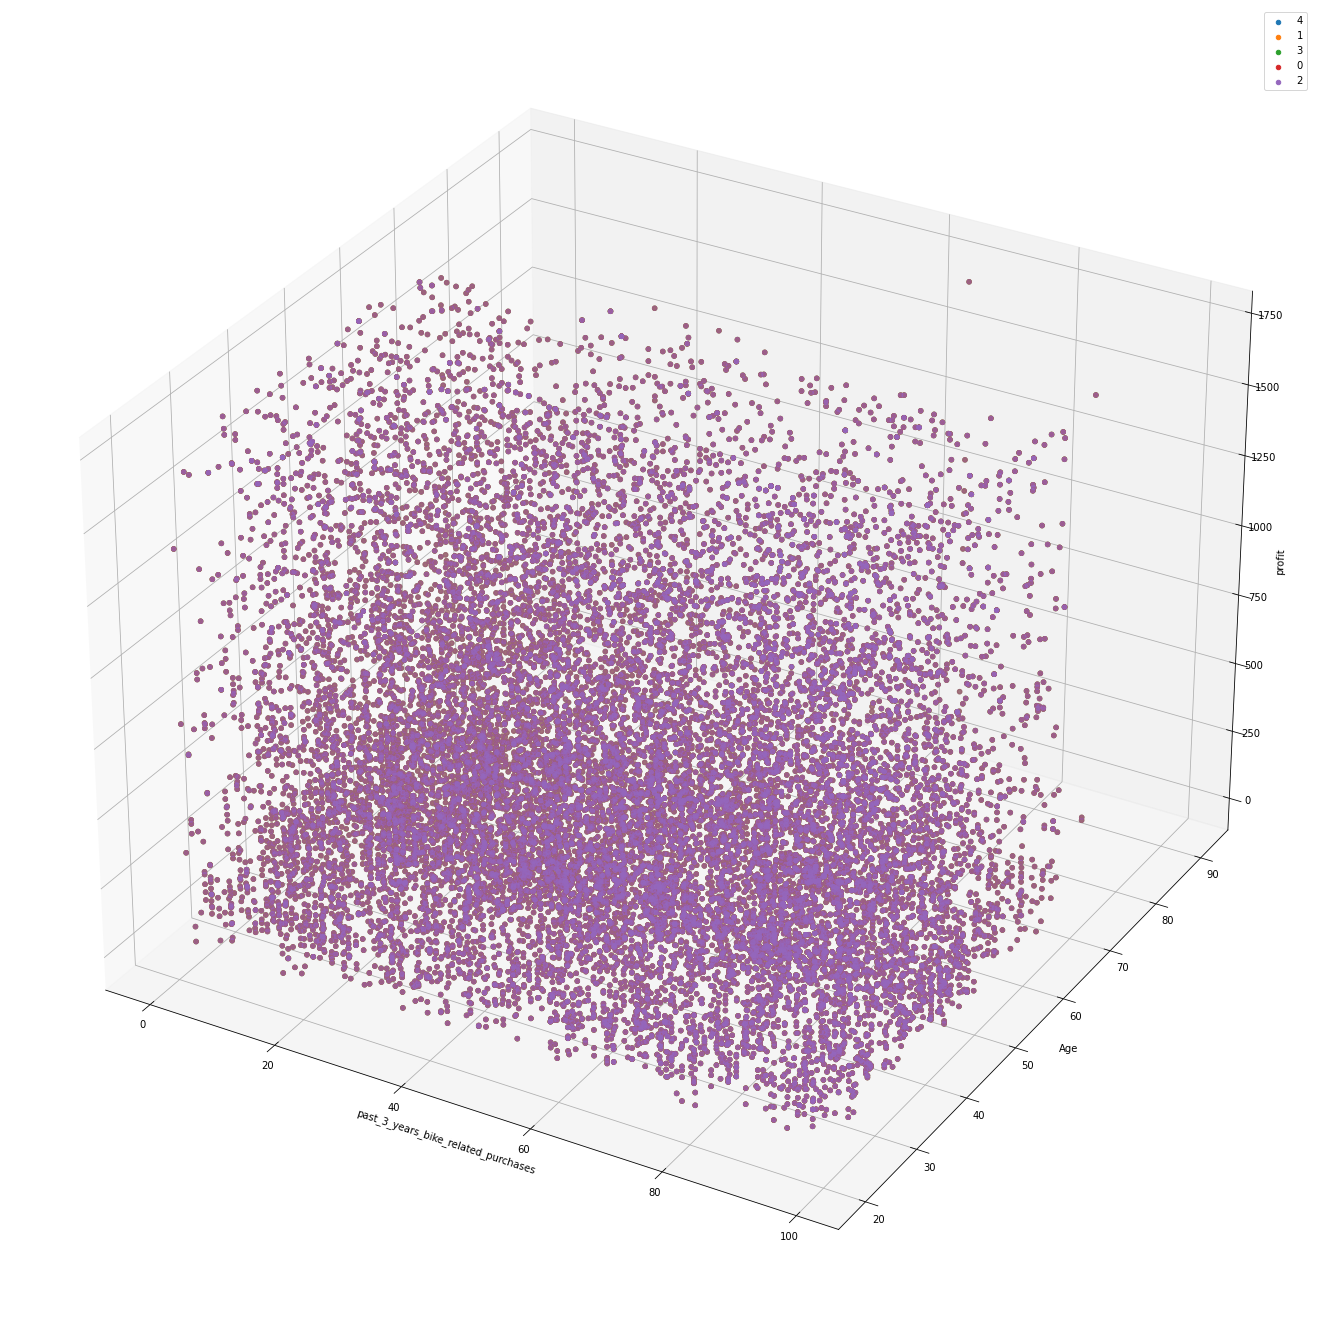

In [ ]:
fig = plt.figure(figsize=(24,24))
ax = fig.add_subplot(111, projection='3d')


for s in df.ClusterLabel.unique():
    ax.scatter(df["past_3_years_bike_related_purchases"],df["Age"],df["profit"],label=s)
ax.set_xlabel('past_3_years_bike_related_purchases')
ax.set_ylabel('Age')
ax.set_zlabel('profit')
ax.legend()

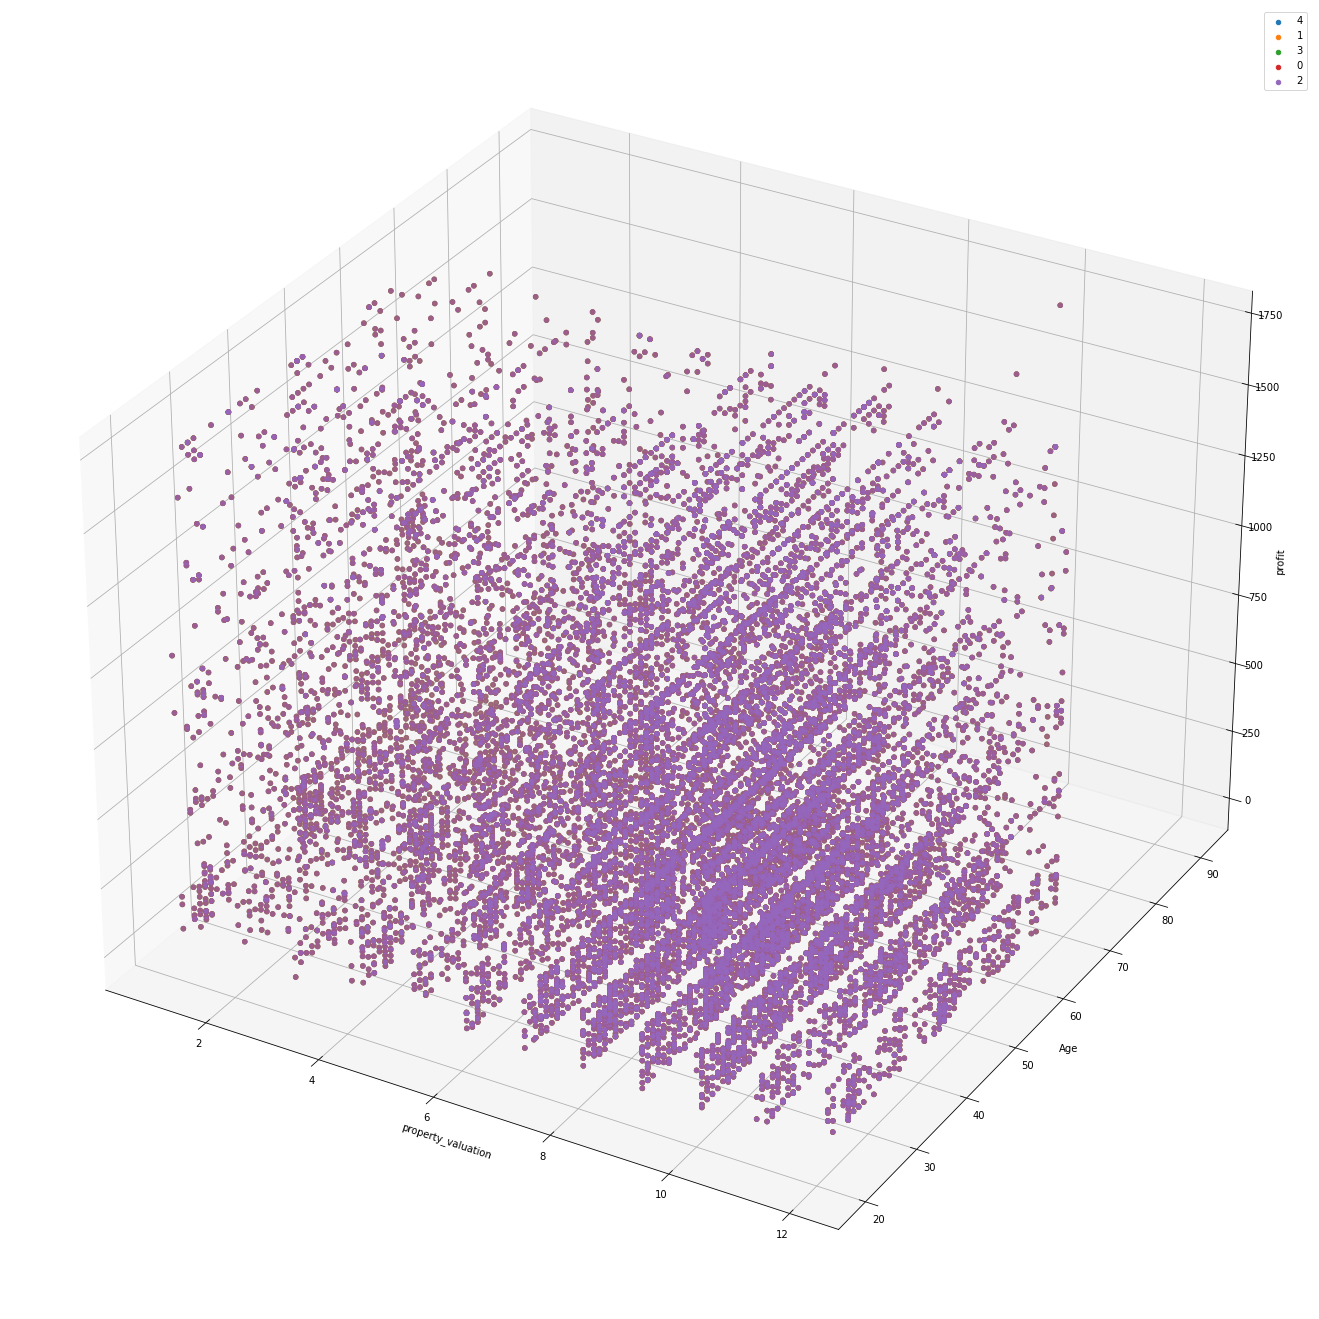

In [ ]:
fig = plt.figure(figsize=(24,24))
ax = fig.add_subplot(111, projection='3d')


for s in df.ClusterLabel.unique():
    ax.scatter(df["property_valuation"],df["Age"],df["profit"],label=s)
ax.set_xlabel('property_valuation')
ax.set_ylabel('Age')
ax.set_zlabel('profit')
ax.legend()

# 